In [1]:
import pdb
from pdb import set_trace as bp
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
from sklearn.model_selection import train_test_split
import sklearn.preprocessing as preprocess
from sklearn.pipeline import Pipeline
from sklearn import decomposition
from sklearn import covariance as cov
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import pyRMT as rmt
import seaborn as sns

In [3]:
from skorch import NeuralNetClassifier
# from skorch.classifier import NeuralNetBinaryClassifier, CVSplit
from skorch.callbacks import EpochScoring

In [4]:
# from sklearn.datasets import fetch_openml
data_dir = '/media/l7/data_storage1/datasets'

In [5]:
data = np.load(data_dir + '/numpy_fashion_mnist_data.npy', allow_pickle=True)
data.shape

(70000, 784)

In [6]:
target = np.load(data_dir + '/numpy_fashion_mnist_target.npy', allow_pickle=True)
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal',
           'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
target.shape

(70000,)

In [7]:
target = np.array(target, dtype=int)

In [8]:
def plot_numpy_images(images,targets, img_shape=[28,28], n_rows=1):
#     bp()
    plt.figure(figsize=(10,10))
    for index, img, label in zip(np.arange(images.shape[0]), images, targets):
        plt.subplot(n_rows, images.shape[0] // n_rows, index + 1)
        img = img.reshape(img_shape)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(img, cmap=plt.cm.Greys)
#         bp()
        plt.xlabel(classes[label])
    plt.tight_layout(w_pad=0)

In [37]:
def plot_confusion_matrix(y_pred, y, prefix_information='',
                          dataset_name='', save_results=False,
                          y_pred_is_predicted_classes=False):
    """
    PLotting confusion matrix of different datasets (train, test, and validation).
    :param y_pred:
    :param y:
    :param prefix_information:
    :param dataset_name:
    :param save_results:
    :param y_pred_is_predicted_classes:
    :return:
    """
    if 'Tensor' in str(type(y)):
        y = y.numpy()
#     bp()
    # _, predicted = torch.max(torch.tensor(y_pred), 1)
#     y_pred = predicted
    
    c_matrix = confusion_matrix(y, y_pred)
    accuracy = accuracy_score(y, y_pred)
    result_accuracy_string = "Accuracy of Net: {:.2f}".format(accuracy)
    print(result_accuracy_string)
    print("\nClassification report:")
    classfication_report_string = classification_report(y, y_pred)
    print(classfication_report_string)
#     plt.figure(figsize=(10,10))
    # plt.title('blah')
    fig, ax = plt.subplots(1, figsize=(10, 10))
    #ax.set_title(dataset_name + " Confusion matrix")
    ax.set_title(" Confusion matrix")
    sns.heatmap(c_matrix, cmap='Blues', 
                annot=True, xticklabels=classes, 
                yticklabels=classes, fmt='g', cbar=False)
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    ax.set_xlabel('predictions')
    ax.set_ylabel('true labels')
    plt.tight_layout(pad=1.08, w_pad=10, h_pad=10)
    # plt.show()
    return accuracy
    

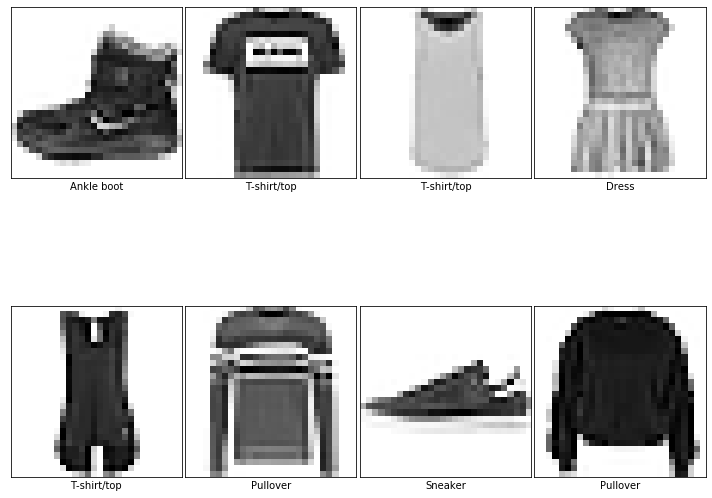

In [9]:
# Show some of the images with their respective labels. 
plot_numpy_images(data[:8],target[:8], n_rows=2)

## Processing Data

Below we are making the images range from [0,1]. Then we apply a standard scaling method, where mean is normalized over the standard deviation of the data. Finally, we visualize the resulting images. 

In [10]:
processed_data = data / 255
standard_scaler = preprocess.StandardScaler()
standard_scaler.fit(processed_data)
processed_data = standard_scaler.transform(processed_data)

In [11]:
processed_data.mean()

-2.9104027254284424e-18

In [12]:
processed_data.std()

1.0000000000000002

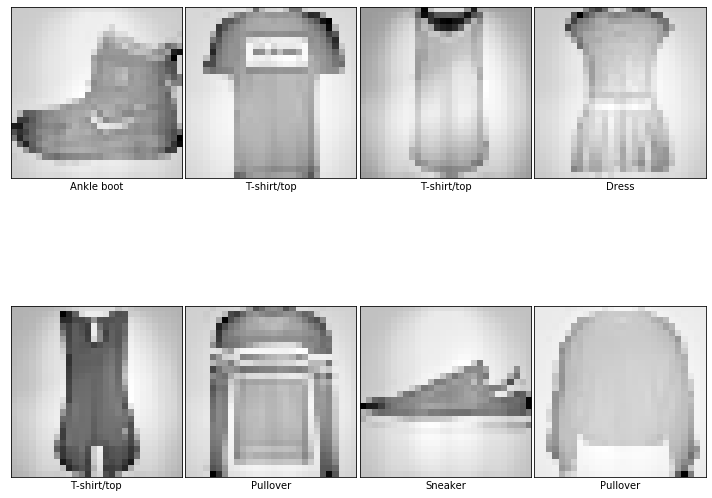

In [13]:
plot_numpy_images(processed_data[:8], target[:8], n_rows=2)

## Inspecting Different Estimators

1. First we look at the Sample Covariance Estimator, and the decorrelated output with the eigenvectors belonging the 49 highest eigenvalues. 
2. Then we consider Ledoit-Wolf Linear Shrunkage Estimator
3. Finally, we look at the output from the Rotationally Invariant Estimator. 

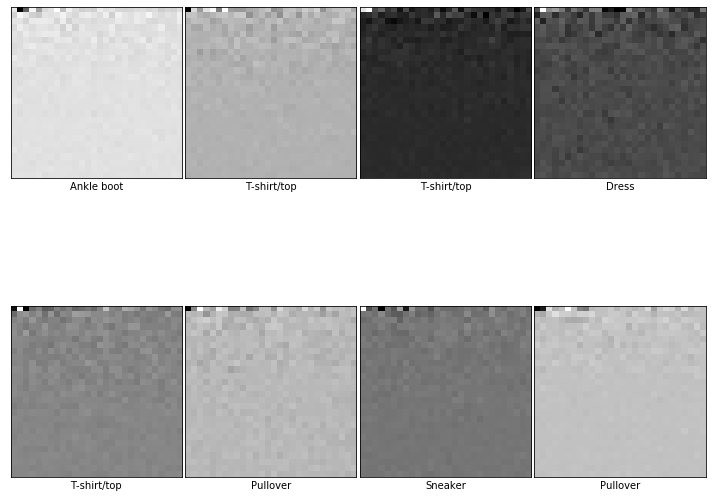

In [34]:
data_cov = np.cov(processed_data, rowvar=False)
eigen_values, eigen_vectors = np.linalg.eig(data_cov)
decorrelated_data_sce = processed_data.dot(eigen_vectors)
plot_numpy_images(decorrelated_data_sce[:8], target[:8], img_shape=[28,28], n_rows=2)

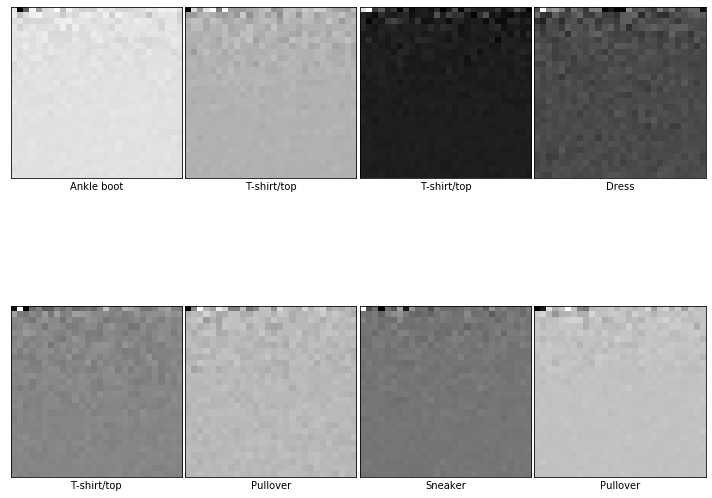

In [94]:
data_cov = cov.ledoit_wolf(processed_data, assume_centered=True)[0]
eigen_values, eigen_vectors = np.linalg.eig(data_cov)
decorrelated_data_lwe = processed_data.dot(eigen_vectors)
plot_numpy_images(decorrelated_data_lwe[:8], target[:8], img_shape=[28,28], n_rows=2)

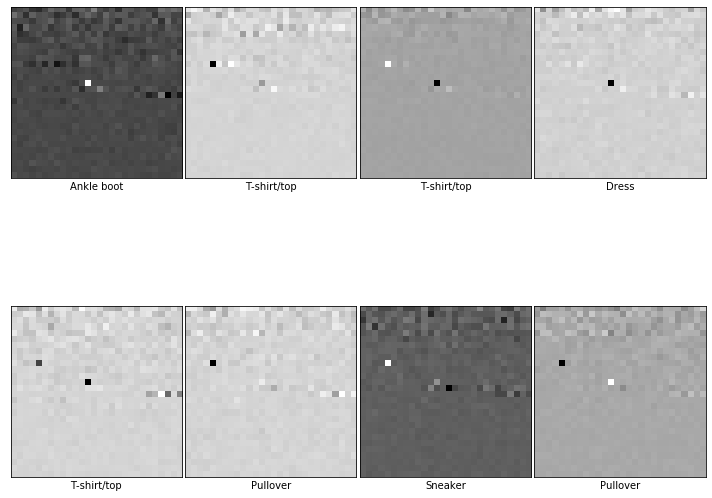

In [95]:
data_cov = rmt.optimalShrinkage(processed_data, return_covariance=True)
eigen_values, eigen_vectors = np.linalg.eig(data_cov)
decorrelated_data_rmt = processed_data.dot(eigen_vectors)
plot_numpy_images(decorrelated_data_rmt[:8], target[:8], img_shape=[28,28], n_rows=2)

In [44]:
def compute_pca(data, number_of_eigen_vectors=None,
                method_name='lwe'):
    if method_name == 'lwe':
        data_cov = cov.ledoit_wolf(data, assume_centered=True)[0]
    elif method_name == 'sce':
        data_cov = np.cov(processed_data, rowvar=False)
    elif method_name == 'rmt':
        data_cov = rmt.optimalShrinkage(processed_data, return_covariance=True)
    else:
        raise Exception('pca method_name incorrect')
    eigen_values, eigen_vectors = np.linalg.eig(data_cov)
    if number_of_eigen_vectors is None:
        decorrelated_data = data.dot(eigen_vectors)
    else:
        decorrelated_data = data.dot(eigen_vectors[:,:number_of_eigen_vectors])
    return decorrelated_data
    

In [14]:
x_train, x_test, y_train, y_test = train_test_split(processed_data, target,
                                                   test_size=0.33, random_state=42)

In [15]:
x_train = x_train.reshape([x_train.shape[0], int(np.sqrt(x_train.shape[1])),int(np.sqrt(x_train.shape[1])) ])

In [16]:
x_test = x_test.reshape([x_test.shape[0], int(np.sqrt(x_test.shape[1])),int(np.sqrt(x_test.shape[1])) ])

In [17]:
x_test.shape

(23100, 28, 28)

In [ ]:
# train_dataset = torch.utils.data.Dataset()
# train_loader = torch.utils.data.DataLoader()

In [35]:
class LeNet5(nn.Module):
    def __init__(self, n_channels, n_features):
        super(LeNet5, self).__init__()
        self.conv2d_1 = nn.Conv2d(1, 16, 5)
        self.name = 'LeNet5'
        self.relu = nn.ReLU()
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2d_2 = nn.Conv2d(16, 32, 5)
        self.fc1 = nn.Linear(32 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        

    def forward(self, x):
#         bp()
        x = self.max_pool(self.relu(self.conv2d_1(x))) # [50, 16, 1, 1]
        # bp()
        x = self.max_pool(self.relu(self.conv2d_2(x)))
        x = x.view(x.shape[0], x.shape[1] * x.shape[2] * x.shape[3])
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [20]:
x_train = torch.tensor(x_train).float().unsqueeze(1)
y_train = torch.tensor(y_train).long()
print(x_train.shape)

torch.Size([46900, 1, 28, 28])


In [21]:
x_test = torch.tensor(x_test).float().unsqueeze(1)
y_test = torch.tensor(y_test).long()
print(x_test.shape)

torch.Size([23100, 1, 28, 28])


In [36]:
device = torch.device('cuda')
model_name = LeNet5.__name__
n_channels = x_train.shape[1]
n_features = x_train.shape[2]
net = LeNet5(n_channels, n_features)
net.to(device)
criterion = nn.CrossEntropyLoss()

with torch.no_grad():
    #bp()
    input_data = torch.tensor(x_train[:50]).float()
    labels = torch.tensor(y_train[:50]).long()
    input_data = input_data.to(device)
    labels = labels.to(device)
    print('Shape of the input tensor:', input_data.shape)
    y = net(input_data)
    loss = criterion(y, labels)
    print('loss: {}'.format(loss))
#     assert y.shape == torch.Size([y_train.shape[0], 10]), "Bad shape of y: y.shape={}".format(y.shape)

print('The shapes seem to be ok.')


Shape of the input tensor: torch.Size([50, 1, 28, 28])
loss: 2.306581497192383
The shapes seem to be ok.


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()
/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':


In [40]:
def train_model(n_features, n_channels, x_train, y_train,
               device = torch.device('cuda'), model_name = LeNet5.__name__,
               model = None, n_epochs = 10):
    if model is None:
        model = NeuralNetClassifier(module=LeNet5, 
                                    criterion=nn.CrossEntropyLoss,
                                    module__n_channels= n_channels,
                                    module__n_features=n_features,
                                    optimizer=optim.Adam, 
                                    optimizer__lr=0.001,
                                    max_epochs=n_epochs, 
                                    batch_size=32,
                                    iterator_train__shuffle=True,
                                    device=device,
                                    warm_start=True,
                                   )
    model.fit(x_train, y_train, epochs=n_epochs)
    pred_train = model.predict(x_train)
    accuracy = plot_confusion_matrix(pred_train, y_train, )
    return model, pred_train, accuracy

def test_model(model, test_data, test_targets):
    pred_test = model.predict(test_data)
    accuracy = plot_confusion_matrix(pred_test, test_targets)
    return pred_test, accuracy

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.5765       0.8468        0.4241  2.8288
      2        0.3611       0.8660        0.3651  2.6748
Accuracy of Net: 0.88

Classification report:
              precision    recall  f1-score   support

           0       0.76      0.91      0.83      4701
           1       0.98      0.98      0.98      4655
           2       0.82      0.85      0.83      4713
           3       0.85      0.93      0.89      4658
           4       0.74      0.88      0.80      4711
           5       0.99      0.93      0.96      4652
           6       0.86      0.40      0.55      4675
           7       0.90      0.98      0.94      4713
           8       0.96      0.98      0.97      4776
           9       0.98      0.94      0.96      4646

   micro avg       0.88      0.88      0.88     46900
   macro avg       0.88      0.88      0.87     46900
weighted avg       0.8

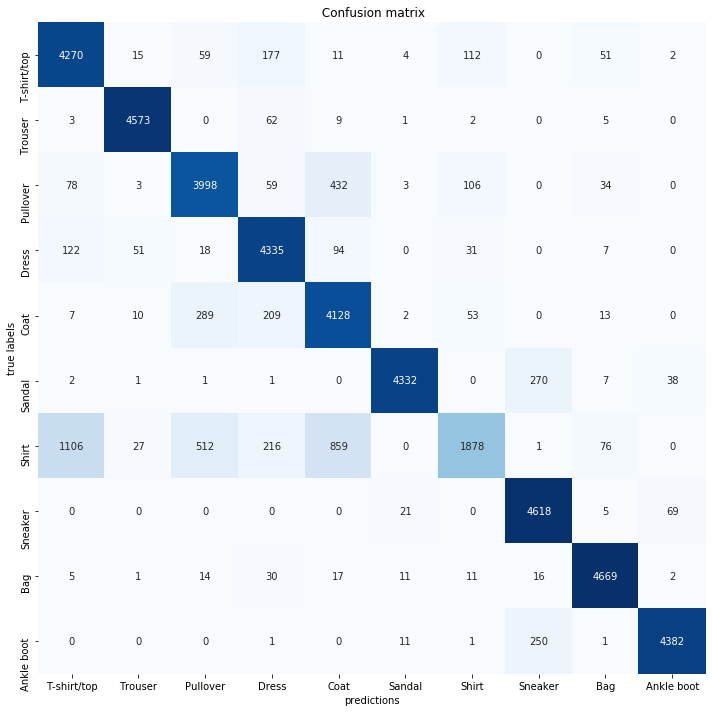

In [42]:
raw_data_model, \
raw_data_pred_train, \
raw_data_accuracy = train_model(n_features=n_features, n_channels=n_channels, 
                                x_train=x_train, y_train=y_train, n_epochs=2)

Accuracy of Net: 0.87

Classification report:
              precision    recall  f1-score   support

           0       0.75      0.90      0.82      2299
           1       0.97      0.98      0.97      2345
           2       0.80      0.84      0.82      2287
           3       0.85      0.92      0.88      2342
           4       0.73      0.85      0.79      2289
           5       0.98      0.93      0.95      2348
           6       0.84      0.39      0.54      2325
           7       0.89      0.97      0.93      2287
           8       0.95      0.97      0.96      2224
           9       0.97      0.94      0.96      2354

   micro avg       0.87      0.87      0.87     23100
   macro avg       0.87      0.87      0.86     23100
weighted avg       0.87      0.87      0.86     23100



(array([4, 7, 0, ..., 3, 1, 2]), 0.8687445887445887)

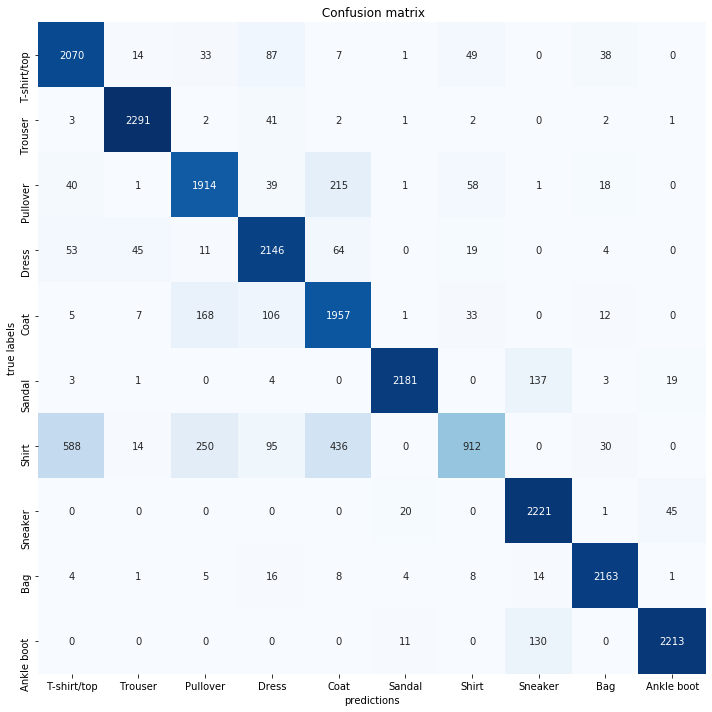

In [43]:
test_model(raw_data_model, x_test, y_test)